[TOC]

## 1. scipy directed_hausdorff Demo

In [1]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np
u = np.array([(1.0, 0.0),
              (0.0, 1.0),
              (-1.0, 0.0),
              (0.0, -1.0)])
v = np.array([(2.0, 0.0),
              (0.0, 2.0),
              (-2.0, 0.0),
              (-2.0, 0.0),
              (0.0, -4.0)])
max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
x = directed_hausdorff(v, u)

# print(x)

## 2. Geographic Distance

In [13]:
from math import cos, pi, hypot
import math

R = 6371229  # 地球的半径

def get_distance_x(longt1, lat1, longt2, lat2):
    return abs(longt2 - longt1) * pi * R * cos(((lat1 + lat2) / 2) * pi / 180) / 180


def get_distance_y(lat1, lat2):
    return abs(lat2 - lat1) * pi * R / 180


def get_distance(longt1, lat1, longt2, lat2):
    return hypot(get_distance_x(longt1, lat1, longt2, lat2), get_distance_y(lat1, lat2))

def calculate_distance_2(slon, slat, dlon, dlat) :
    angle_to_radian = math.pi / 180.0
    slat *= angle_to_radian
    dlat *= angle_to_radian
    slon *= angle_to_radian
    dlon *= angle_to_radian
    c = math.sin(slat) * math.sin(dlat) + math.cos(slat) * math.cos(dlat) * math.cos(slon - dlon)
    if c > 1.0:
        c = 1.0
    return R * math.acos(c)
print('get_distance 1', get_distance(116.273342,40.040242,116.301412,39.869666))
print('get_distance 2', calculate_distance_2(116.273342,40.040242,116.301412,39.869666))

get_distance 1 19118.181952380604
get_distance 2 19118.181607578757


In [18]:
from math import floor
import math
def normalize_longitude(d):
    if d == -180.0:
        return -180.0
    else:
        sign = 1 if d > 0 else -1
        x = abs(d) / 360.0
        x2 = (x - floor(x)*1.0) * 360
        if x2 >= 180:
            x2 -= 360
        return x2 * sign


def convert_xy(lon, lat):
    x = lon * pi * R / 180 
    y = lat * pi * R / 180 * cos(lat * pi / 180)
    return x, y

def convert_xy_2(lon, lat):
    x = normalize_longitude(lon)
    y = lat
    return x, y

def coors_tencent_mercator_to_gcj02ll(lng_lat):
    """
    :param: [12970171.73,4851965.33]
    :return: [116.51302944444444,39.90376305555556]
    """
    x = lng_lat[0]
    y = lng_lat[1]
    x = x / 111319.49077777777777777777777778;
    dbl_mercator_lat = y / 111319.49077777777777777777777778;
    y = math.atan(
        math.exp(dbl_mercator_lat * 0.017453292519943295769236907684886)) / 0.0087266462599716478846184538424431 - 90;
    return [x, y]

def coors_gcj02ll_to_tencent_mercator(lng_lat):
    """
    :param: [116.51302944444444,39.90376305555556]
    :return: [12970171.73,4851965.33]
    """
    x = round((lng_lat[0] * 111319.49077777777777777777777778), 2)
    y = math.log(math.tan((90 + lng_lat[1]) * 0.0087266462599716478846184538424431)) / 0.017453292519943295769236907684886
    y = round((y * 111319.49077777777777777777777778), 2)
    return [x, y]


def trajectory_insert_point_between(distance_threshold, coordinates):
    """
    间隔 #{distance} 在轨迹中插入点
    :param distance_threshold: 间隔距离
    :param coordinates: 轨迹点的坐标

    geojson coordinate
    [
        [lon, lat],
        [lon, lat]
    ]
    :return:
    """
    ret = []
    coordinates_len = len(coordinates)
    if distance_threshold <= 0:
        return coordinates
    if coordinates_len > 1:
        for i in range(coordinates_len - 1):
            curr_point = coordinates[i]
            ret.append(curr_point)
            next_point = coordinates[i + 1]
            d = get_distance(curr_point[0], curr_point[1], next_point[0], next_point[1])
            count = d / distance_threshold
            if count > 1:
                count = math.ceil(count)
                delta_x = (next_point[0] - curr_point[0]) / count
                delta_y = (next_point[1] - curr_point[1]) / count
                for j in range(count):
                    ret.append([curr_point[0] + (j+1) * delta_x, curr_point[1] + (j+1) * delta_y])
        ret.append(coordinates[-1])
    return ret


def forward_similarity_by_distance(coord_list1, coord_list2, valid_distance=150):
    """
    通过比较距离，来比较两个坐标序列的相似度

    前提:
        两个坐标序列的疏密程度要相似，并且每隔 #{valid_distance} 距离范围内，必须补充坐标点

    Complexity：
        O(n^2)

    :param coord_list1: 坐标序列1
    :param coord_list2: 坐标序列2
    :param valid_distance 偏差的最小距离
    :return:
    """
    matched_count = 0
    start_idx_coord2 = 0
    for coord in coord_list1:
        for j in range(start_idx_coord2, len(coord_list2)):
            coord2 = coord_list2[j]
            dis = get_distance(coord[0], coord[1], coord2[0], coord2[1])
            if dis < valid_distance:
                matched_count += 1
                start_idx_coord2 = j
                break
    if len(coord_list1) == 0:
        return 0
    return matched_count * 1.0 / len(coord_list1)

MAX_DEVIATION_DISTANCE = 150  # 最大距离偏差
SIMILARITY_THRESHOLD = 0.99  # 相似度判定的阈值
DEFAULT_INSERT_POINT_STEP_DISTANCE = 30  # 默认插点的阶段距离

def similarity_assert(coord_list1, coord_list2):
    """
    通过比较距离，来比较两个坐标序列的相似度
    内部会实现插点，前后调换等运算

    :param coord_list1:
    :param coord_list2:
    :return: (True/False, sim1_2, sim2_1)
        True Similar
        False Not Similar
    """
    coord_list1 = trajectory_insert_point_between(DEFAULT_INSERT_POINT_STEP_DISTANCE, coord_list1)
    coord_list2 = trajectory_insert_point_between(DEFAULT_INSERT_POINT_STEP_DISTANCE, coord_list2)
    sim1_2 = forward_similarity_by_distance(coord_list1, coord_list2, MAX_DEVIATION_DISTANCE)
    sim2_1 = forward_similarity_by_distance(coord_list2, coord_list1, MAX_DEVIATION_DISTANCE)
    sim = min(sim1_2, sim2_1)
    return sim > SIMILARITY_THRESHOLD, sim1_2, sim2_1


## 3. 使用 directed_hausdorff 来计算两个轨迹之间的相似度

1. 计算相似度，并保存必要的结果的数据
2. 排序 + 可视化
3. 度量

注意事项

* **首条比较：不同图商，我们更看重的是首条的规划路线是否相同**


### 3.1 尝试用多种相似度比较的方法来实现

In [1]:
import json, sys


def add_to_case_map(route_map, routes_arr, case_type):
    for item in routes_arr:
        route_id = item[1]
        case_id = item[0]
        json_obj = json.loads(item[2])
        route = json_obj['route']
        start_link = json_obj['links'][0]
        end_link = json_obj['links'][-1]
        if case_id not in route_map:
            route_map[case_id] = dict()
        obj = {}
        obj['case_id'] = case_id
        obj['len'] = json_obj['length']
        obj['route'] = route
        obj['route_id'] = route_id
        obj['start_link'] = start_link
        obj['end_link'] = end_link
        route_map[case_id][case_type] = obj
    return route_map


file1 = "/Users/andyzhuang/git/andyzhuang/workflow-py/route_compare/ext/data/gaode_normal_route_20190830.csv"
file2 = "/Users/andyzhuang/git/andyzhuang/workflow-py/route_compare/ext/data/tencent_normal_route_20190830.csv"

def parse_to_route_collection(file1, file2):
    """
    :return: 
        route_map
        {
            "case_id": {
                "gaode": {}, // case
                "tencent": {} // case
            }
        }
    """
    routes1 = []
    with open(file1, 'r') as f:
        for line in f:
            routes1.append(line.split('\t'))
    routes2 = []
    with open(file2, 'r') as f:
        for line in f:
            routes2.append(line.split('\t'))

    print('len routes1', len(routes1))
    print('len routes2', len(routes2))


    route_map = dict()
    route_map = add_to_case_map(route_map, routes1, "gaode")
    route_map = add_to_case_map(route_map, routes2, 'tencent')

    print("route_map (case) size: ", len(route_map))
    return route_map

def generate_pair_case(route_map):
    """
    :param: route_map
        {
            "case_id": {
                "gaode": {}, // case
                "tencent": {} // case
            }
        }
    :return: 
        the case pair
        case_result_map 
        {
            "case_id": {
                "case_id": "",
                "route_a":
                "route_b":
                ...
            }
        }
    """
    route_compare_result_map = {}
    trans_func = coors_gcj02ll_to_tencent_mercator
    # trans_func = lambda x: x

    # Update
    # Generate pair of case_a and case_b
    # use only first route each case
    for case_id, case in route_map.items():
        route_id = case_id.split('_')[0]
        # 取第一条路
        if case_id[-2:] != '_0':
            continue
        if 'gaode' not in case:
            print('gaode not in case {}'.format(route_id), file=sys.stderr)
            continue
        if 'tencent' not in case:
            print('tencent not in case {}'.format(route_id), file=sys.stderr)
            continue
        a = case['gaode']
        b = case['tencent']

        i = 0
        case_a = a
        case_b = b
    #     for case_a in a:
    #         for case_b in b:
        case_pair_result = {}
        case_pair_result['route_id'] = route_id
        case_pair_result['case_cross_id'] = case_id
        route_a = case_a['route']
        route_b = case_b['route']
        len_a = case_a['len']
        len_b = case_b['len']
        start_a = case_a['start_link']
        start_b = case_b['start_link']
        end_a = case_a['end_link']
        end_b = case_b['end_link']
        start_eq = start_a == start_b
        end_eq = end_a == end_b
        
        narray_a = np.array([trans_func([x[0], x[1]]) for x in route_a])
        narray_b = np.array([trans_func([x[0], x[1]]) for x in route_b])
        case_pair_result['narray_a'] = narray_a
        case_pair_result['narray_b'] = narray_b
        case_pair_result['len_a'] = len_a
        case_pair_result['len_b'] = len_b
        case_pair_result['start_eq'] = start_eq
        case_pair_result['end_eq'] = end_eq
        case_pair_result['start_a'] = start_a
        case_pair_result['start_b'] = start_b
        case_pair_result['end_a'] = end_a
        case_pair_result['end_b'] = end_b
        case_pair_result['route_a'] = route_a
        case_pair_result['route_b'] = route_b

        route_compare_result_map[case_id] = case_pair_result
        i += 1
    return route_compare_result_map
        
def compare_by_directed_hausdorff(route_compare_result_map):
    """
    :param: route_compare_result_map
        the same as return 
    :return: 
        case_result_map 
        {
            "case_id": {
                "case_id": "",
                "route_a":
                "route_b":
                ...
            }
        }
    """
    compare_func = directed_hausdorff

    # directed_hausdorff compare    
    for case_id,case_pair_result in route_compare_result_map.items():
        len_a = case_pair_result['len_a']
        len_b = case_pair_result['len_b']
        u = case_pair_result['narray_a']
        v = case_pair_result['narray_b']
        route_a = case_pair_result['route_a']
        route_b = case_pair_result['route_b']
        
        # 方法1
        b_ret, sim1_2, sim2_1 = similarity_assert(route_a, route_b)
        
        # 方法2
        dh1 = compare_func(u, v)
        dh2 = compare_func(v, u)
        max_dh = max(dh1[0], dh2[0])
        # 异常点
        e = np.array([u[dh1[1]], v[dh1[2]], v[dh2[1]], u[dh2[2]]])
        case_pair_result['e'] = e
        case_pair_result['dh'] = max_dh
        case_pair_result['dh_radio'] = max_dh * 2/ (len_a + len_b)
        case_pair_result['sim'] = min(sim1_2, sim2_1)
        
        print("sim: ", case_id, case_pair_result['dh_radio'], b_ret, sim1_2, sim2_1)

    key_func = lambda x: x['dh_radio']            
    # for k, v in route_compare_result_map.items():
    #     v.sort(key=key_func)

    route_compare_result = [x for k,x in route_compare_result_map.items()]
    route_compare_result.sort(key=key_func)

    route_compare_score = [(x['case_cross_id'], x['dh'], x['dh_radio'], x['len_a'], x['len_b'], x['start_eq'], x['end_eq']) for x in route_compare_result]

    print('route_compare_result_map size:', len(route_compare_result_map))
    print('route_compare_score size:', len(route_compare_score))
    for x in route_compare_score:
        print(x)
    return route_compare_result_map

def compare_by_similarity_by_distance(route_compare_result_map):
    """
    :param: route_compare_result_map
        the same as return 
    :return: 
        case_result_map 
        {
            "case_id": {
                "case_id": "",
                "route_a":
                "route_b":
                ...
            }
        }
    """
    compare_func = directed_hausdorff

    # directed_hausdorff compare    
    for case_id,case_pair_result in route_compare_result_map.items():
        len_a = case_pair_result['len_a']
        len_b = case_pair_result['len_b']
        route_a = case_pair_result['route_a']
        route_b = case_pair_result['route_b']
        b_ret, sim1_2, sim2_1 = similarity_assert(route_a, route_b)
        print("sim: ", case_id, b_ret, sim1_2, sim2_1)

        case_pair_result['sim'] = min(sim1_2, sim2_1)

    key_func = lambda x: 1 - x['sim']            

    route_compare_result = [x for k,x in route_compare_result_map.items()]
    route_compare_result.sort(key=key_func)

    route_compare_score = [(x['case_cross_id'], x['sim'], x['len_a'], x['len_b'], x['start_eq'], x['end_eq']) for x in route_compare_result]

    print('route_compare_result_map size:', len(route_compare_result_map))
    print('route_compare_score size:', len(route_compare_score))
    for x in route_compare_score:
        print(x)
    return route_compare_result_map

        
        

### 可视化

In [32]:
route_map = parse_to_route_collection(file1, file2)
route_result = generate_pair_case(route_map)
route_result = compare_by_directed_hausdorff(route_result)
# route_result = compare_by_similarity_by_distance(route_result)

len routes1 344
len routes2 330
route_map (case) size:  363
sim:  3077779615294436936_0 0.10322962792952456 True 1.0 1.0
sim:  6976536426253122334_0 0.33205262427880805 False 0.09047619047619047 0.09645669291338582
sim:  8581591826779114466_0 0.3303167360317549 False 0.12389380530973451 0.26540284360189575
sim:  7589431898314430110_0 0.07982558479620294 True 1.0 1.0
sim:  8744967133734973732_0 0.00821667402033 True 1.0 1.0
sim:  4390022520921385808_0 0.05083062599505284 False 0.9813084112149533 1.0
sim:  7114327770407133416_0 0.19259875587984365 False 0.7641621943947525 0.6490086741016109
sim:  7659560783160821380_0 0.12474477403003395 False 0.9671916010498688 0.8055190538764783
sim:  8005945435073778786_0 0.19505253491520785 False 0.197480881691408 0.19687026754164563
sim:  5829248658445999796_0 0.31215558457943793 False 0.2430647291941876 0.2596964586846543
sim:  2568009494984120968_0 0.07815813981794534 True 1.0 1.0
sim:  5953560150094683670_0 0.13299540634985696 False 0.71172248803

sim:  5239909128670615154_0 0.2971243200377992 False 0.37750385208012327 0.4206773618538324
sim:  2512157913340228734_0 0.3161394010041761 False 0.33816425120772947 0.3225806451612903
sim:  1138343580281610436_0 0.012852283802814623 False 0.9870272647317502 0.973917205072984
sim:  548105663390530844_0 0.033305846294277755 True 1.0 1.0
sim:  1295072765759002000_0 0.11708896761799112 True 1.0 1.0
sim:  1378714062822772468_0 0.36180534142197035 False 0.1191969887076537 0.11183144246353323
sim:  8451275440907499840_0 0.009068705759826878 True 1.0 1.0
sim:  4249934115015464086_0 0.0449716728799154 True 1.0 1.0
sim:  8327582601396499708_0 0.03858208757274105 False 0.8173387096774194 0.9109433962264151
sim:  4388537481895436628_0 0.017156453881901606 True 1.0 1.0
sim:  1249913202112534678_0 0.2481139429484612 True 1.0 1.0
sim:  1482607477416862568_0 0.11625813309805236 True 1.0 1.0
sim:  4060773446230077790_0 0.42311678357621924 False 0.056155507559395246 0.03146067415730337
sim:  92231569899

<IPython.core.display.Javascript object>


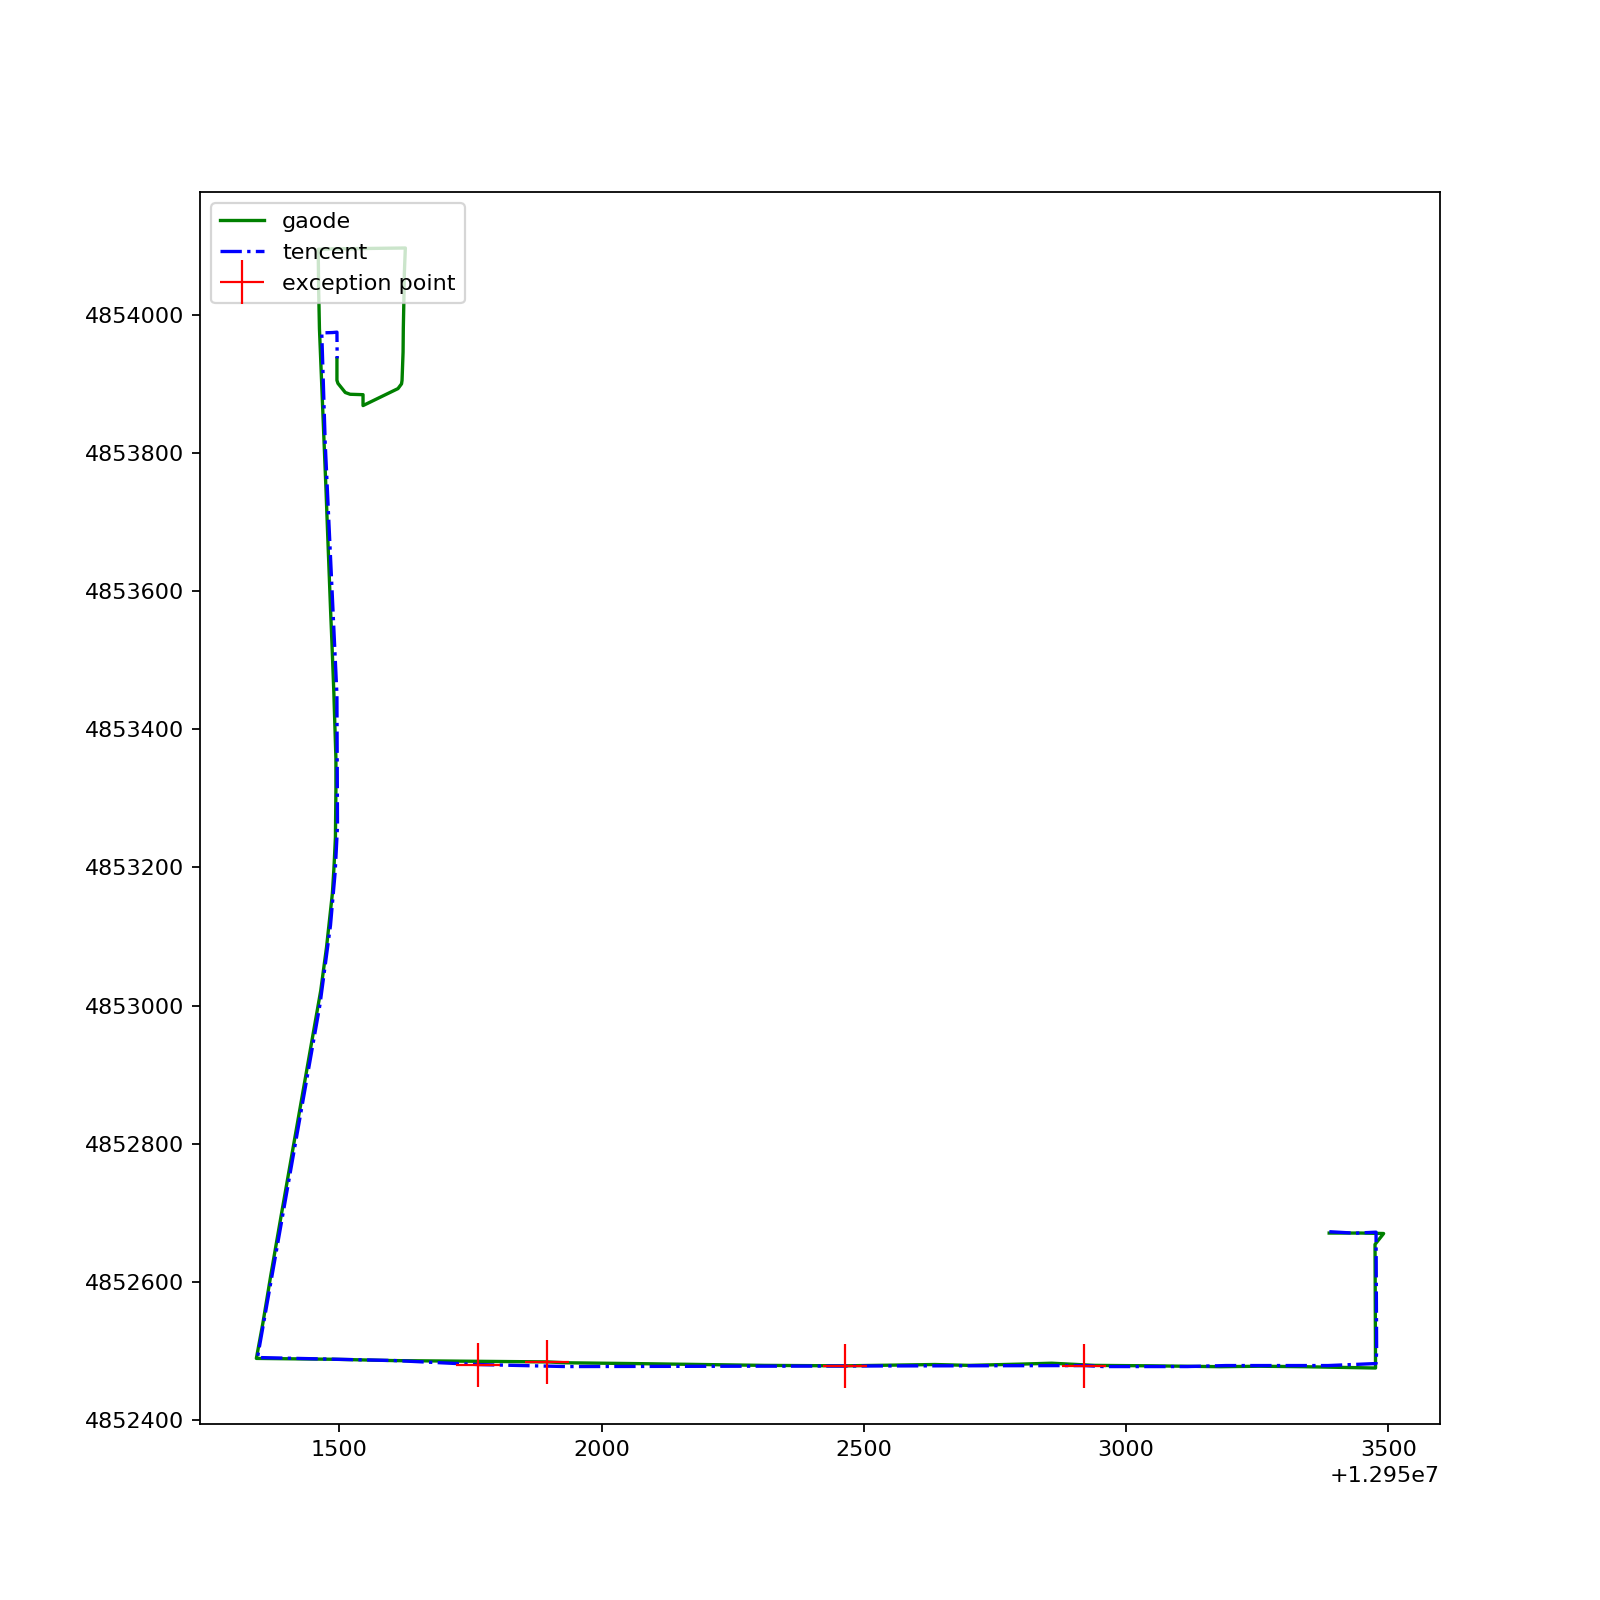

route_id 3083883211595902092
case_cross_id 3083883211595902092_0
len_a 3516
len_b 3052
start_eq True
end_eq False
start_a 12644857
start_b 12644857
end_a 424703
end_b 439444
dh 456.5901752117146
dh_radio 0.13903476711684368
sim 1.0


In [33]:
case_cross_id = '3083883211595902092_0'
case = route_result[case_cross_id]
u = case['narray_a']
v = case['narray_b']
e = case['e'] if 'e' in case else None

# visualization
import matplotlib.pyplot as plt
%matplotlib notebook
fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
if e is not None:
    plt.plot(u[:,0], u[:,1], 'g-', v[:,0], v[:,1], 'b-.', e[:,0], e[:,1], 'r+', markersize=20)
else:
    plt.plot(u[:,0], u[:,1], 'g-', v[:,0], v[:,1], 'b-.')
    
plt.legend(('gaode', 'tencent', 'exception point',), loc='upper left')
plt.show()
for k,v in case.items():
    if k not in ['narray_a', 'narray_b', 'e', 'route_a', 'route_b']:
        print(k, v)

## matplot 可视化的 demo，尝试性的

(135, 2) (92, 2)
(298.16799710796585, 76, 50) (122.62345982832106, 39, 63)
[[12957520.61  4837347.64]
 [12957222.48  4837342.88]
 [12958216.57  4837661.68]
 [12958094.12  4837655.16]]


<IPython.core.display.Javascript object>


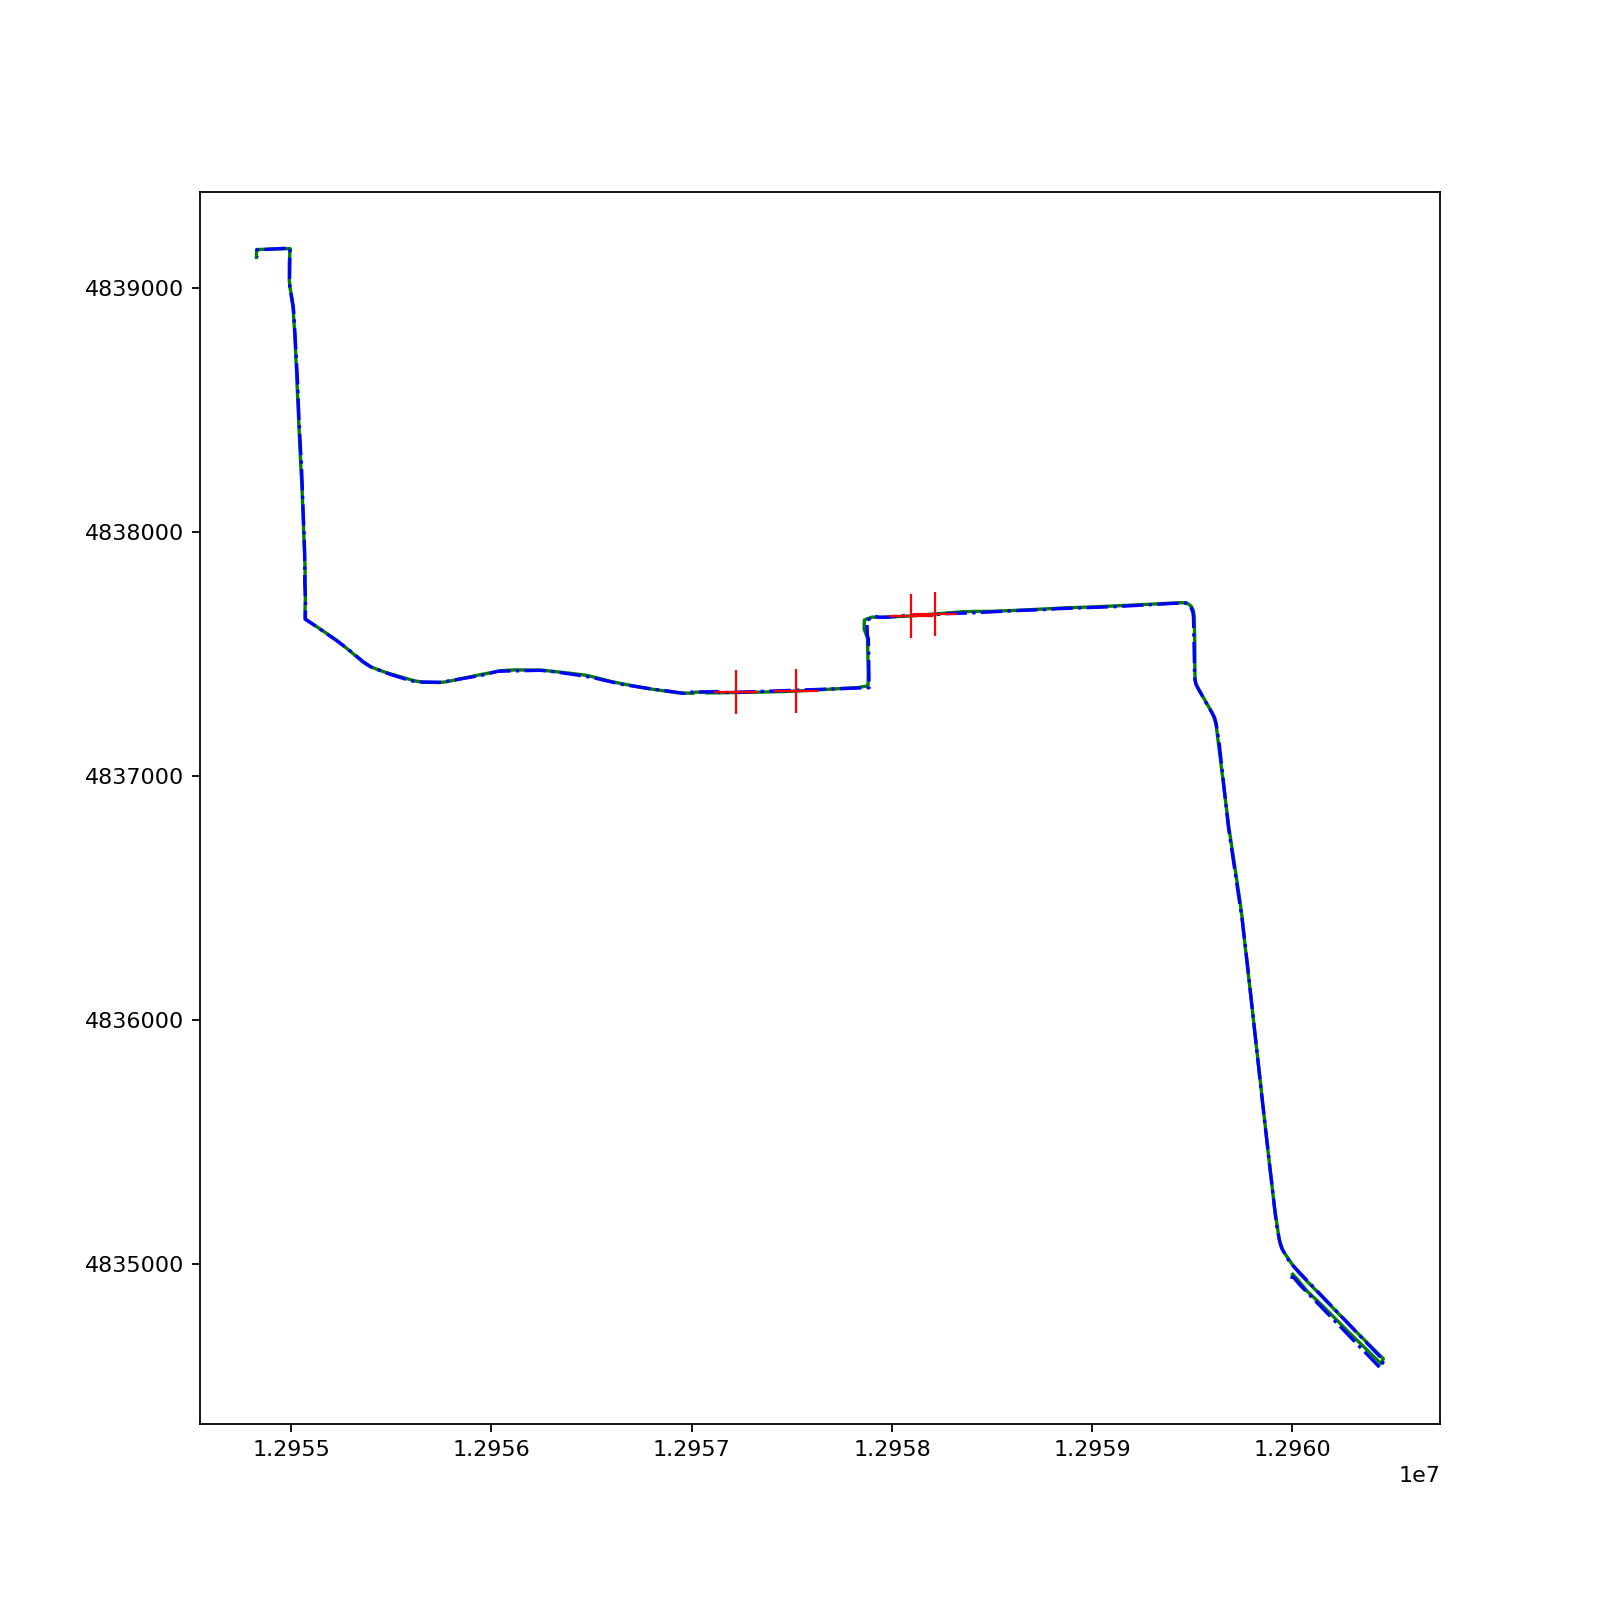

In [11]:
import numpy as np

gaode = [[116.42166666666667, 39.786458333333336], [116.42185333333333, 39.78633694444444], [116.42232194444445, 39.78598083333333], [116.42301638888888, 39.78556416666667], [116.42421, 39.78480916666667], [116.42424055555556, 39.78478722222222], [116.42505222222222, 39.7842925], [116.425625, 39.78393222222222], [116.42573777777778, 39.78407111111111], [116.42573777777778, 39.78407111111111], [116.42433166666666, 39.78495222222222], [116.42194888888889, 39.786501666666666], [116.4216275, 39.78675777777778], [116.42124138888889, 39.78711805555555], [116.42109388888889, 39.78738722222222], [116.42104611111111, 39.78752611111111], [116.42098527777777, 39.78779083333333], [116.42085083333333, 39.788359444444446], [116.42063805555556, 39.78953138888889], [116.420625, 39.789591944444446], [116.42021277777778, 39.79195305555555], [116.42011722222222, 39.792478333333335], [116.42003027777778, 39.79296], [116.41986555555556, 39.79390638888889], [116.41957888888889, 39.79549472222222], [116.41951388888889, 39.79586805555556], [116.41939666666667, 39.7965625], [116.41930555555555, 39.79700527777778], [116.41902777777777, 39.79816833333334], [116.41880638888888, 39.79908861111111], [116.41879777777778, 39.79913194444445], [116.41834638888889, 39.801415], [116.41824222222222, 39.80195305555556], [116.4181988888889, 39.80207472222222], [116.41810777777778, 39.80224833333333], [116.41810777777778, 39.80224833333333], [116.41806, 39.802326388888886], [116.41769111111111, 39.80273], [116.41766055555556, 39.802769166666664], [116.41746083333334, 39.80298166666667], [116.41735666666666, 39.80312055555556], [116.41730472222223, 39.80321611111111], [116.41729611111111, 39.803268333333335], [116.41728305555556, 39.80346361111111], [116.41728305555556, 39.80380638888889], [116.41727861111112, 39.80424055555556], [116.4172525, 39.805065], [116.41720916666667, 39.80522583333333], [116.41717444444444, 39.80527333333333], [116.4171136111111, 39.80534277777778], [116.4171136111111, 39.80534277777778], [116.41701388888889, 39.805395], [116.41685333333334, 39.805438333333335], [116.41652777777777, 39.805438333333335], [116.41450944444445, 39.805373333333335], [116.41254777777777, 39.80531694444444], [116.41162333333334, 39.805299444444444], [116.41122833333333, 39.80528638888889], [116.41113277777778, 39.805282222222225], [116.40934472222222, 39.80522583333333], [116.4080686111111, 39.80519527777778], [116.40751305555555, 39.80519527777778], [116.4068925, 39.805186666666664], [116.40454, 39.805065], [116.40310777777778, 39.80502611111111], [116.4028125, 39.805034722222224], [116.40245666666667, 39.80495222222222], [116.40245666666667, 39.80495222222222], [116.40244361111111, 39.804700555555556], [116.40259555555555, 39.80444444444444], [116.40259972222222, 39.80433166666667], [116.40263027777777, 39.80346361111111], [116.40263027777777, 39.80345055555556], [116.40262166666666, 39.80309472222222], [116.40262166666666, 39.80309472222222], [116.40218305555555, 39.8030425], [116.39938805555556, 39.80294277777778], [116.39772138888888, 39.802912222222226], [116.39537333333334, 39.80289055555556], [116.39529083333333, 39.802912222222226], [116.39485666666667, 39.802912222222226], [116.39478722222222, 39.802881944444444], [116.3941275, 39.80289055555556], [116.39262166666667, 39.80302527777778], [116.39113722222223, 39.8032075], [116.39055111111111, 39.80330305555555], [116.39002611111111, 39.80338555555556], [116.38915805555555, 39.803455], [116.38900166666667, 39.80346361111111], [116.38802083333333, 39.803533055555555], [116.38678833333333, 39.80354166666667], [116.38616333333333, 39.80352], [116.38571611111111, 39.80346361111111], [116.38529944444444, 39.80341583333333], [116.383685, 39.80320305555556], [116.38336805555555, 39.80318583333333], [116.38290361111112, 39.80319], [116.38266055555556, 39.80319444444444], [116.38227, 39.80323361111111], [116.38120666666667, 39.80342888888889], [116.38102444444445, 39.80346361111111], [116.38099833333334, 39.803467777777776], [116.38059027777778, 39.803559166666666], [116.38026055555555, 39.803645833333334], [116.38010861111111, 39.80370222222222], [116.379935, 39.803780277777776], [116.37904083333333, 39.80425361111111], [116.378815, 39.80436638888889], [116.37736111111111, 39.80499138888889], [116.37736111111111, 39.80499138888889], [116.37736555555556, 39.805277777777775], [116.37738277777778, 39.805638055555555], [116.37737416666667, 39.80603305555555], [116.37736555555556, 39.80644111111111], [116.37722666666667, 39.808728333333335], [116.37719194444445, 39.80908], [116.37719194444445, 39.80908], [116.377105, 39.81023861111111], [116.37701833333334, 39.811484444444446], [116.37700944444444, 39.81162333333333], [116.37700083333333, 39.81175361111111], [116.37694888888889, 39.812486944444444], [116.37692277777778, 39.81281694444444], [116.37683166666666, 39.81375], [116.37674916666667, 39.81411888888889], [116.37667972222222, 39.81439666666667], [116.37667527777778, 39.81445305555555], [116.37665805555555, 39.81455722222222], [116.37665805555555, 39.81501305555555], [116.37668416666666, 39.815351666666665], [116.37669277777778, 39.815446944444446], [116.37669277777778, 39.815446944444446], [116.37519527777778, 39.815421111111114], [116.37519527777778, 39.815421111111114], [116.37518222222222, 39.815199722222225]]
tencent = [[116.42156903027394, 39.78637870184693], [116.42170997594204, 39.78637000409768], [116.42196860091235, 39.78617444250881], [116.42559995061738, 39.78380998781188], [116.42559995061738, 39.78380998781188], [116.42574996926984, 39.78401998383541], [116.42160999345089, 39.7867499428493], [116.42151998225941, 39.78681993860408], [116.42133995987646, 39.78700997602894], [116.421189941224, 39.787179994536984], [116.42112993376301, 39.78727994838053], [116.42107001613356, 39.78742994790227], [116.42093994008039, 39.78787994450522], [116.4203436383947, 39.79116098584831], [116.41958995187122, 39.79548995664189], [116.41939995818859, 39.79649999682121], [116.41879000211058, 39.79907996993447], [116.41838001101485, 39.80142995885379], [116.41823996366205, 39.80201996254891], [116.41816998490141, 39.802189874944645], [116.41788000872766, 39.80251996756613], [116.41764995018337, 39.80274998935715], [116.41758994272239, 39.80283998267171], [116.41739410999041, 39.80305419941297], [116.41731999897947, 39.80314998941509], [116.41726996281812, 39.80333998172617], [116.41725999151848, 39.803775864754016], [116.41721992665678, 39.80501000052439], [116.41719001275783, 39.80517997454248], [116.4170799691355, 39.80534994814033], [116.41700936155416, 39.80540467361453], [116.41689994675255, 39.805430000521625], [116.4162699582437, 39.80541992496842], [116.41370993934666, 39.80532993503047], [116.41116079006456, 39.80527217302205], [116.41066995059325, 39.805249951543516], [116.40935993741424, 39.80522000084372], [116.40717999571396, 39.80514995480124], [116.40600994005622, 39.80512994163314], [116.40564001382218, 39.80510999747017], [116.4044299831343, 39.8050799776984], [116.40342000726024, 39.80502994471635], [116.40312994125496, 39.80502994471635], [116.40287994011135, 39.80505996450998], [116.40287994011135, 39.80505996450998], [116.40256993150676, 39.80493995426798], [116.4025905927583, 39.8045087023942], [116.40263739498462, 39.804425198358274], [116.40267000382944, 39.803039982729814], [116.40267000382944, 39.803039982729814], [116.39670995141306, 39.80290989304112], [116.39595994798225, 39.802899955144966], [116.39586993679077, 39.80292997586855], [116.39447997355146, 39.80290989304109], [116.39439993365963, 39.802879941321976], [116.39432995489899, 39.802879941321976], [116.39359998389902, 39.80294998967699], [116.39304994545047, 39.8029899482633], [116.39152999598953, 39.8031399825407], [116.39022995411017, 39.80332997487946], [116.38983999544527, 39.80337000225765], [116.38856995729641, 39.80348994622727], [116.38788993262624, 39.803529973512326], [116.38600598581212, 39.80350298960374], [116.38528993869903, 39.803389946925336], [116.38374106348594, 39.8032212797263], [116.38357999555548, 39.80318994788516], [116.38245000475943, 39.80319995475227], [116.38208034801997, 39.803240603321626], [116.38120997034106, 39.80340996059985], [116.38033995198828, 39.803619896793634], [116.37995358658452, 39.80378207586017], [116.37946993363548, 39.80403997429431], [116.3787999700965, 39.80435998232579], [116.37802993423483, 39.80469993315563], [116.37738000312669, 39.80496990508979], [116.37738000312669, 39.80496990508979], [116.37738997442634, 39.80536989223373], [116.3773519756898, 39.80600968739785], [116.37734999939617, 39.806849879640936], [116.37721965384843, 39.80909919798452], [116.3770899371214, 39.81068999680514], [116.37702543808399, 39.81173183173743], [116.37685996840862, 39.813659992063464], [116.37682996467814, 39.81383988101203], [116.37669000715685, 39.81434994331883], [116.37666997472601, 39.81453997368129], [116.37669449873327, 39.81546396640502], [116.37669449873327, 39.81546396640502], [116.37520994289453, 39.81540993894447], [116.37520994289453, 39.81540993894447], [116.37523213128206, 39.81520424780254]]

u = np.array([coors_gcj02ll_to_tencent_mercator([x[0], x[1]]) for x in gaode])
v = np.array([coors_gcj02ll_to_tencent_mercator([x[0], x[1]]) for x in tencent])
print(u.shape, v.shape)

dh1 = directed_hausdorff(u, v)
dh2 = directed_hausdorff(v, u)
# print(u)
x = max(dh1[0], dh2[0])
# x = directed_hausdorff(v, u)
print(dh1, dh2)

# 异常点
e = np.array([u[dh1[1]], v[dh1[2]], v[dh2[1]], u[dh2[2]]])
print(e)

import matplotlib.pyplot as plt
%matplotlib notebook
fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(u[:,0], u[:,1], 'g-', v[:,0], v[:,1], 'b-.', e[:,0], e[:,1], 'r+', markersize=20)

## 笔记

* direct_hausdorff 如果两组数据，疏密程度不同，是否有很大影响

不需要精确的计算距离，所以都转化成投影的墨卡托坐标系，墨卡托坐标，计算空间几何的距离